Model accuracy of yield prediction on new core test set when using only fractions of the batches.
* Goal is to see whether we got most of the performance early, or if more data would still improve the model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from rdkit import Chem
from rdkit.Chem import inchi
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
import scipy
from scipy import stats

plt.rcParams.update({"font.size":9})
custom_palette = ['#005EB8', '#C4476E', '#008C95', '#4F5199', "#B0B0B0"]
sns.set_palette(palette=custom_palette)

In [3]:
df_exp = pd.read_csv("../data/experimental_results_final.csv", index_col=0).dropna(subset=["CAD Yield (%)"])

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_exp.shape

(1291, 2148)

In [5]:
def read_mol_sdf(filename):
    # read a stack of molecules from SDF
    molecules = []
    with Chem.rdmolfiles.SDMolSupplier(filename, removeHs=False) as supplier:
        for idx, mol in enumerate(supplier):
            molecules.append(mol)
    return molecules

def sdf2df(sdf_file, annotate=False):
    mols = read_mol_sdf(sdf_file)
    mols = [m for m in mols if m is not None]
    mol_properties = []
    for mol in mols:
        propd = mol.GetPropsAsDict()
        propd["smiles"] = Chem.MolToSmiles(mol)
        propd["inchikey"] = inchi.MolToInchiKey(mol, options="/FixedH")    
        propd["mol"] = mol
        propd["Name"] = mol.GetProp("_Name")
        mol_properties.append(propd)
    df = pd.DataFrame(mol_properties)
    return df

In [7]:
# load results from iteration selections for new cores
#df = PandasTools.LoadSDF('/home/rickena1/modules/mcds-actlearn/notebooks/iterations/batch_c1/selections.sdf')
df = sdf2df("iterations/batch_4/selections.sdf")
df.head(3)

,smiles,inchikey,mol,Name
0,COc1ccc(OCCBr)cc1,PRRJGZRMBVOTGG-UHFFFAOYNA-N,<rdkit.Chem.rdchem.Mol object at 0x7fbf61f23e10>,
1,FC(F)(F)c1cccc(OCCBr)c1,NZOCBKYAZHDTDD-UHFFFAOYNA-N,<rdkit.Chem.rdchem.Mol object at 0x7fbf61f23db0>,
2,CC12CC3CC(Br)(C1)CC(C(=O)O)(C3)C2,AQYMJKFAOHCXOD-YHMJCDSINA-N,<rdkit.Chem.rdchem.Mol object at 0x7fbf61f23d50>,


In [8]:
df["selection_order"] = df.index
df.head(3)

,smiles,inchikey,mol,Name,selection_order
0,COc1ccc(OCCBr)cc1,PRRJGZRMBVOTGG-UHFFFAOYNA-N,<rdkit.Chem.rdchem.Mol object at 0x7fbf61f23e10>,,0
1,FC(F)(F)c1cccc(OCCBr)c1,NZOCBKYAZHDTDD-UHFFFAOYNA-N,<rdkit.Chem.rdchem.Mol object at 0x7fbf61f23db0>,,1
2,CC12CC3CC(Br)(C1)CC(C(=O)O)(C3)C2,AQYMJKFAOHCXOD-YHMJCDSINA-N,<rdkit.Chem.rdchem.Mol object at 0x7fbf61f23d50>,,2


In [9]:
# map KB ordering to what was actually selected for the new cores batch
df_exp["selection"].value_counts()

active_learning_2           96
random_1                    95
random_3                    93
test_2                      91
random_4                    90
unexplored                  90
high_yield                  87
active_learning_3           86
random_2                    84
initial_diverse             83
active_learning_1           76
test_1                      70
cores2_test_1               45
cores2_active_learning_1    45
cores2_active_learning_2    44
cores2_test_2               40
test_3                      32
cross_active_learning       30
cross_random                14
Name: selection, dtype: int64

In [10]:
df_train = df_exp[df_exp["selection"].isin(["initial_diverse", "active_learning_1", "active_learning_2", "active_learning_3"])]
df_test = df_exp[df_exp["selection"].isin(["cores2_test_1", "cores2_test_2"])]
df_nc = df_exp[df_exp["selection"].isin(["cores2_active_learning_1", "cores2_active_learning_2"])]

In [11]:
df_test["smiles_aryl"].value_counts()

COCc1cccc(OC)c1Br          22
COC(=O)Cc1cc(F)cc(Br)c1    22
COC(=O)c1cccc(Br)c1C       21
COc1cc(-n2ccnc2)ccc1Br     20
Name: smiles_aryl, dtype: int64

In [12]:
print(df_nc["smiles_alkyl"].isin(df["smiles"]).value_counts())
print(df["smiles"].isin(df_nc["smiles_alkyl"]).value_counts())

True    89
Name: smiles_alkyl, dtype: int64
True     24
False     6
Name: smiles, dtype: int64


In [13]:
df_mnc = df_nc.merge(df[["smiles", "selection_order"]].rename(columns={"smiles":"smiles_alkyl"}), left_on="smiles_alkyl", right_on="smiles_alkyl")

In [14]:
df_mnc.sort_values(by="selection_order", inplace=True, ascending=True)
df_mnc

,inchikey_short,smiles,smiles_alkyl,smiles_aryl,rsmi,CAD Yield (%),selection,category,inchikey,rsmi_mapped,...,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm,inchikey_alkyl,inchikey_alkyl_short,selection_order
56,CVPWBIQRWZTXII,COc1ccc(OCCc2ccc(-n3ccnc3)cc2OC)cc1,COc1ccc(OCCBr)cc1,COc1cc(-n2ccnc2)ccc1Br,COc1ccc(OCCBr)cc1.COc1cc(-n2ccnc2)ccc1Br>>COc1...,60.037187,cores2_active_learning_1,NaN,CVPWBIQRWZTXII-UHFFFAOYNA-N,NaN,...,0.0401,0.0399,0.0519,0.1172,0.1094,0.0855,0.1230,PRRJGZRMBVOTGG-UHFFFAOYNA-N,PRRJGZRMBVOTGG,0
55,PJGVIEGRMJUQFL,COCc1cccc(OC)c1CCOc1ccc(OC)cc1,COc1ccc(OCCBr)cc1,COCc1cccc(OC)c1Br,COc1ccc(OCCBr)cc1.COCc1cccc(OC)c1Br>>COCc1cccc...,27.135434,cores2_active_learning_1,NaN,PJGVIEGRMJUQFL-UHFFFAOYNA-N,NaN,...,0.0401,0.0399,0.0519,0.1172,0.1094,0.0855,0.1230,PRRJGZRMBVOTGG-UHFFFAOYNA-N,PRRJGZRMBVOTGG,0
57,LMYJXJVBMJJREV,COC(=O)c1cccc(CCOc2ccc(OC)cc2)c1C,COc1ccc(OCCBr)cc1,COC(=O)c1cccc(Br)c1C,COc1ccc(OCCBr)cc1.COC(=O)c1cccc(Br)c1C>>COC(=O...,100.800000,cores2_active_learning_1,NaN,LMYJXJVBMJJREV-UHFFFAOYNA-N,NaN,...,0.0401,0.0399,0.0519,0.1172,0.1094,0.0855,0.1230,PRRJGZRMBVOTGG-UHFFFAOYNA-N,PRRJGZRMBVOTGG,0
24,JSRQQGSUWZRISR,COC(=O)Cc1cc(F)cc(CCOc2cccc(C(F)(F)F)c2)c1,FC(F)(F)c1cccc(OCCBr)c1,COC(=O)Cc1cc(F)cc(Br)c1,FC(F)(F)c1cccc(OCCBr)c1.COC(=O)Cc1cc(F)cc(Br)c...,0.000000,cores2_active_learning_2,NaN,JSRQQGSUWZRISR-UHFFFAOYNA-N,NaN,...,0.1235,0.1264,0.1328,0.1231,0.1148,0.0992,0.1262,NZOCBKYAZHDTDD-UHFFFAOYNA-N,NZOCBKYAZHDTDD,1
25,SNTLDDOXVJDMJV,COC(=O)c1cccc(CCOc2cccc(C(F)(F)F)c2)c1C,FC(F)(F)c1cccc(OCCBr)c1,COC(=O)c1cccc(Br)c1C,FC(F)(F)c1cccc(OCCBr)c1.COC(=O)c1cccc(Br)c1C>>...,0.000000,cores2_active_learning_2,NaN,SNTLDDOXVJDMJV-UHFFFAOYNA-N,NaN,...,0.1235,0.1264,0.1328,0.1231,0.1148,0.0992,0.1262,NZOCBKYAZHDTDD-UHFFFAOYNA-N,NZOCBKYAZHDTDD,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,PWFXNBSTEXBTDG,COCc1cccc(OC)c1C(C)(C)C(=O)OC(C)(C)C,CC(C)(C)OC(=O)C(C)(C)Br,COCc1cccc(OC)c1Br,CC(C)(C)OC(=O)C(C)(C)Br.COCc1cccc(OC)c1Br>>COC...,0.000000,cores2_active_learning_1,NaN,PWFXNBSTEXBTDG-UHFFFAOYNA-N,NaN,...,0.3269,0.3450,0.3094,0.3704,0.3408,0.3303,0.3369,IGVNJALYNQVQIT-UHFFFAOYNA-N,IGVNJALYNQVQIT,28
29,BUZQGEUAQHPGKL,COC(=O)c1cccc(CCOc2ccc(C=O)cc2OC)c1C,COc1cc(C=O)ccc1OCCBr,COC(=O)c1cccc(Br)c1C,COc1cc(C=O)ccc1OCCBr.COC(=O)c1cccc(Br)c1C>>COC...,72.422971,cores2_active_learning_2,NaN,BUZQGEUAQHPGKL-UHFFFAOYNA-N,NaN,...,0.0248,0.0246,0.0331,0.0215,0.0184,0.0183,0.0254,VFSWCDPTQADMSM-UHFFFAOYNA-N,VFSWCDPTQADMSM,29
28,FNNCOEAPVSIIQR,COC(=O)Cc1cc(F)cc(CCOc2ccc(C=O)cc2OC)c1,COc1cc(C=O)ccc1OCCBr,COC(=O)Cc1cc(F)cc(Br)c1,COc1cc(C=O)ccc1OCCBr.COC(=O)Cc1cc(F)cc(Br)c1>>...,65.002569,cores2_active_learning_2,NaN,FNNCOEAPVSIIQR-UHFFFAOYNA-N,NaN,...,0.0248,0.0246,0.0331,0.0215,0.0184,0.0183,0.0254,VFSWCDPTQADMSM-UHFFFAOYNA-N,VFSWCDPTQADMSM,29
27,CDOSKWLHPTZWLY,COc1cc(-n2ccnc2)ccc1CCOc1ccc(C=O)cc1OC,COc1cc(C=O)ccc1OCCBr,COc1cc(-n2ccnc2)ccc1Br,COc1cc(C=O)ccc1OCCBr.COc1cc(-n2ccnc2)ccc1Br>>C...,7.510168,cores2_active_learning_2,NaN,CDOSKWLHPTZWLY-UHFFFAOYNA-N,NaN,...,0.0248,0.0246,0.0331,0.0215,0.0184,0.0183,0.0254,VFSWCDPTQADMSM-UHFFFAOYNA-N,VFSWCDPTQADMSM,29


In [15]:
f_cols = [c for c in df_exp.columns if c.startswith("f_")]
target = "CAD Yield (%)"
print(len(f_cols))

2135


In [16]:
def score_regression(y_val, y_pred):
    performance = {}
    performance["r2"] = metrics.r2_score(y_val, y_pred)
    performance["mae"] = metrics.mean_absolute_error(y_val, y_pred)
    performance["rmse"] = metrics.mean_squared_error(y_val, y_pred, squared=False)
    performance["spearmanr"] = scipy.stats.spearmanr(y_val, y_pred)
    return performance


In [17]:
assert len(df_mnc["smiles_alkyl"].unique()) == len(df_mnc["selection_order"].unique())

In [18]:
df_mnc["selection_order"].unique()

array([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 20, 22,
       23, 24, 25, 26, 27, 28, 29])

In [19]:
df_exp["selection"].value_counts()

active_learning_2           96
random_1                    95
random_3                    93
test_2                      91
random_4                    90
unexplored                  90
high_yield                  87
active_learning_3           86
random_2                    84
initial_diverse             83
active_learning_1           76
test_1                      70
cores2_test_1               45
cores2_active_learning_1    45
cores2_active_learning_2    44
cores2_test_2               40
test_3                      32
cross_active_learning       30
cross_random                14
Name: selection, dtype: int64

In [25]:
df_test_all = df_exp[df_exp["selection"].str.contains("test")]
df_rand = df_exp[df_exp["selection"].str.contains("random_")]

# only include data from true active learning and initial sampling batches (exclude post-iteration analysis batches)
df_al = df_exp[df_exp["selection"].isin(["initial_diverse", "active_learning_1", "active_learning_2", "active_learning_3", "cores2_active_learning_1", "cores2_active_learning_2"])]
print(df_test_all.shape, df_rand.shape, df_al.shape)

(278, 2148) (362, 2148) (430, 2148)


In [26]:
df_al["selection_group"] = "Active Learning"
df_rand["selection_group"] = "Random"
df_test_all["selection_group"] = "Test"
dfc = pd.concat([df_al, df_rand, df_test_all])

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [27]:
dfc.rename(columns={"selection_group":"Group"}, inplace=True)

In [28]:
fig = px.histogram(dfc, x="CAD Yield (%)", log_y=True, pattern_shape="Group",
             color='Group', barmode='group', nbins=13,
             height=400, width=400)

fig.update_layout(
    yaxis_title="Count",
    font=dict(family="Arial", color="black", size=14),
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99, bordercolor="Gray", borderwidth=2, title=None),
    margin={'t':0,'l':0,'b':0,'r':0},
    paper_bgcolor="white",
    plot_bgcolor="white",
    xaxis=dict(showline=True, showgrid=True, ticks="outside", linewidth=1, linecolor='black', mirror=True, tickfont = dict(size=14)),
    yaxis=dict(showline=True, linewidth=1, showgrid=True, ticks="outside", linecolor='black', mirror=True, tickfont = dict(size=14)),
    )

full_fig = fig.full_figure_for_development(warn=False)
range_dict = full_fig['data'][0]['xbins']
xtick_arr = np.arange(range_dict.start, range_dict.end+range_dict.size, range_dict.size)
xtick_arr = xtick_arr[1:]
fig.update_xaxes(tickvals=xtick_arr)

fig.update_yaxes(tickvals=[1,10,100])

pio.write_image(fig, 'images/histyield_plotly_fewerticks.png',scale=6, width=400, height=400)

In [29]:
# RMSE with error bars

def root_mean_squared_error(
        y_true,
        y_pred,
        ci_method=None,
        alpha=0.025
        ):

    sse = np.sum(np.square(y_true - y_pred))
    mse = np.mean(np.square(y_true - y_pred))
    N = len(y_true)

    if ci_method is None:
        return np.sqrt(mse)
    elif ci_method == "chi_squared":
        # See the paper: Confidence limits, error bars and method comparison
        # in molecular modeling. Part 1: The calculation of confidence intervals
        # by A. Nicholls
        c1, c2 = stats.chi2.ppf([alpha, 1 - alpha], N - 1)
        upper = sse / c1
        lower = sse / c2
        return np.sqrt(mse), np.sqrt(lower), np.sqrt(upper)

In [30]:
# train model on og core data + adding data for new cores 1 alkyl bromide at a time
threshold = 10

df_train_aug = df_train.copy() # so we don't muss up df_train when we add new core data to it
model = RandomForestRegressor(n_jobs=-1, n_estimators=150, random_state=42)
model.fit(df_train_aug[f_cols], df_train_aug[target])
pred = model.predict(df_test[f_cols])
model_results = {0: score_regression(df_test[target], pred)}
rmse, rmse_lower, rmse_higher = root_mean_squared_error(df_test[target], pred, ci_method="chi_squared")
model_results[0]["rmse_v"] = rmse
model_results[0]["rmse_lower"] = rmse_lower
model_results[0]["rmse_upper"] = rmse_higher
model_results[0][f"acc_20"] = sklearn.metrics.accuracy_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
model_results[0][f"recall_20"] = sklearn.metrics.recall_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
model_results[0][f"precision_20"] = sklearn.metrics.precision_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
model_results[0][f"f1_20"] = sklearn.metrics.f1_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
precision, recall, _ = sklearn.metrics.precision_recall_curve(df_test["CAD Yield (%)"] > threshold, pred)
model_results[0]["prc-auc_20"] = sklearn.metrics.auc(recall, precision)

for num_mol, i in enumerate(df_mnc["selection_order"].unique()):
    df_mnc_next = df_mnc[df_mnc["selection_order"] == i] # next alkyl bromide to add
    assert len(df_mnc_next["smiles_alkyl"].unique()) == 1
    df_train_aug = pd.concat([df_train_aug, df_mnc_next])
    print(num_mol, df_train_aug.shape)

    model = RandomForestRegressor(n_jobs=-1, n_estimators=150, random_state=42)
    model.fit(df_train_aug[f_cols], df_train_aug[target])
    pred = model.predict(df_test[f_cols])
    rmse, rmse_lower, rmse_higher = root_mean_squared_error(df_test[target], pred, ci_method="chi_squared")
    model_results[num_mol+1] = score_regression(df_test[target], pred)
    model_results[num_mol+1]["rmse_v"] = rmse
    model_results[num_mol+1]["rmse_lower"] = rmse_lower
    model_results[num_mol+1]["rmse_upper"] = rmse_higher
    model_results[num_mol+1][f"acc_20"] = sklearn.metrics.accuracy_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
    model_results[num_mol+1][f"recall_20"] = sklearn.metrics.recall_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
    model_results[num_mol+1][f"precision_20"] = sklearn.metrics.precision_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
    model_results[num_mol+1][f"f1_20"] = sklearn.metrics.f1_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(df_test["CAD Yield (%)"] > threshold, pred)
    model_results[num_mol+1]["prc-auc_20"] = sklearn.metrics.auc(recall, precision)

model_results

0 (344, 2149)
1 (348, 2149)
2 (352, 2149)
3 (356, 2149)
4 (360, 2149)
5 (363, 2149)
6 (367, 2149)
7 (371, 2149)
8 (373, 2149)
9 (377, 2149)
10 (381, 2149)
11 (384, 2149)
12 (388, 2149)
13 (392, 2149)
14 (396, 2149)
15 (399, 2149)
16 (402, 2149)
17 (406, 2149)
18 (410, 2149)
19 (414, 2149)
20 (418, 2149)
21 (422, 2149)
22 (426, 2149)
23 (430, 2149)


{0: {'r2': 0.24792012898685734,
  'mae': 16.27159101668291,
  'rmse': 29.694181440275027,
  'spearmanr': SpearmanrResult(correlation=0.469615728391665, pvalue=5.785011565787041e-06),
  'rmse_v': 29.694181440275027,
  'rmse_lower': 25.95648740913632,
  'rmse_upper': 35.1852214430314,
  'acc_20': 0.7176470588235294,
  'recall_20': 0.6190476190476191,
  'precision_20': 0.4482758620689655,
  'f1_20': 0.52,
  'prc-auc_20': 0.6003511273845132},
 1: {'r2': 0.3020395312705766,
  'mae': 16.033057456516595,
  'rmse': 28.605845460778756,
  'spearmanr': SpearmanrResult(correlation=0.5113951519204468, pvalue=5.686693132478175e-07),
  'rmse_v': 28.605845460778756,
  'rmse_lower': 25.005143483205106,
  'rmse_upper': 33.89563066848806,
  'acc_20': 0.7176470588235294,
  'recall_20': 0.6190476190476191,
  'precision_20': 0.4482758620689655,
  'f1_20': 0.52,
  'prc-auc_20': 0.6299003292339536},
 2: {'r2': 0.2690543041766049,
  'mae': 15.456270584759755,
  'rmse': 29.273990787641992,
  'spearmanr': Spearm

In [36]:
df_pred = pd.DataFrame.from_dict(model_results, orient="index")

In [37]:
df_pred["iter"] = df_pred.index

In [38]:
df_pred

,r2,mae,rmse,spearmanr,rmse_v,rmse_lower,rmse_upper,acc_20,recall_20,precision_20,f1_20,prc-auc_20,iter
0,0.247920,16.271591,29.694181,"(0.469615728391665, 5.785011565787041e-06)",29.694181,25.956487,35.185221,0.717647,0.619048,0.448276,0.520000,0.600351,0
1,0.302040,16.033057,28.605845,"(0.5113951519204468, 5.686693132478175e-07)",28.605845,25.005143,33.895631,0.717647,0.619048,0.448276,0.520000,0.629900,1
2,0.269054,15.456271,29.273991,"(0.5193184551675851, 3.5340420331851406e-07)",29.273991,25.589187,34.687329,0.764706,0.619048,0.520000,0.565217,0.683537,2
3,0.238552,15.320641,29.878543,"(0.5067162096129446, 7.48904799288645e-07)",29.878543,26.117643,35.403676,0.788235,0.619048,0.565217,0.590909,0.666680,3
4,0.229367,16.012827,30.058217,"(0.48407189448324034, 2.683200884781462e-06)",30.058217,26.274701,35.616575,0.752941,0.619048,0.500000,0.553191,0.646292,4
5,0.215480,15.922041,30.327836,"(0.4649588565667453, 7.355209016462851e-06)",30.327836,26.510382,35.936051,0.752941,0.571429,0.500000,0.533333,0.635085,5
6,0.218158,15.948253,30.276027,"(0.4416965679247294, 2.3191304236879686e-05)",30.276027,26.465094,35.874662,0.752941,0.523810,0.500000,0.511628,0.629060,6
7,0.207521,15.537230,30.481278,"(0.48702933914930313, 2.2829808375248414e-06)",30.481278,26.644509,36.117867,0.764706,0.523810,0.523810,0.523810,0.645024,7
8,0.287901,15.221930,28.894120,"(0.4667465656559325, 6.7102634204095445e-06)",28.894120,25.257132,34.237213,0.776471,0.619048,0.541667,0.577778,0.674230,8
9,0.319950,15.012048,28.236424,"(0.48164414139915895, 3.0602206509082862e-06)",28.236424,24.682222,33.457895,0.752941,0.619048,0.500000,0.553191,0.677803,9


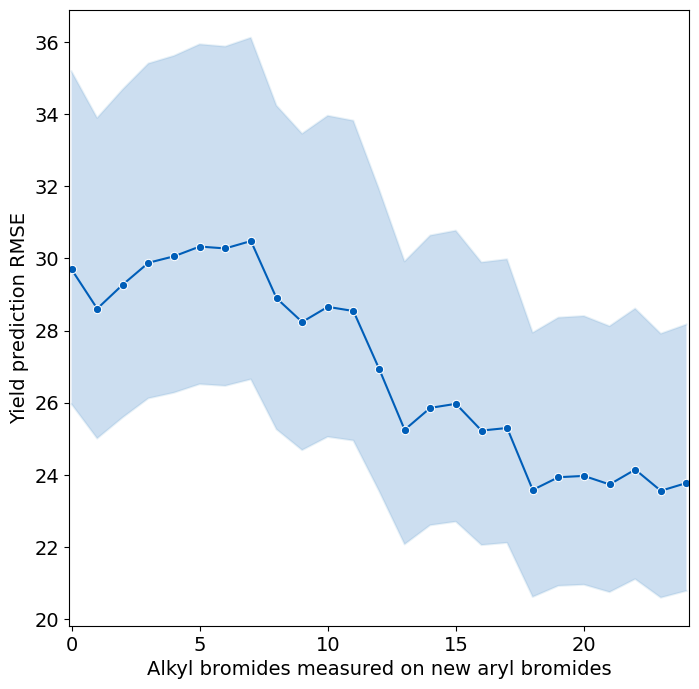

In [40]:
plt.figure(figsize=(8,8))
sns.lineplot(data=df_pred, x="iter", y="rmse", marker="o", )
plt.plot(df_pred["iter"], df_pred["rmse_upper"], color="tab:blue", alpha=0.1)
plt.plot(df_pred["iter"], df_pred["rmse_lower"], color="tab:blue", alpha=0.1)
plt.fill_between(df_pred["iter"], df_pred["rmse_lower"], df_pred["rmse_upper"], alpha=0.2)
plt.ylabel("Yield prediction RMSE")
plt.xlabel("Alkyl bromides measured on new aryl bromides")
plt.xlim([-0.1,24.1])
#plt.ylim([0,30])
plt.show()

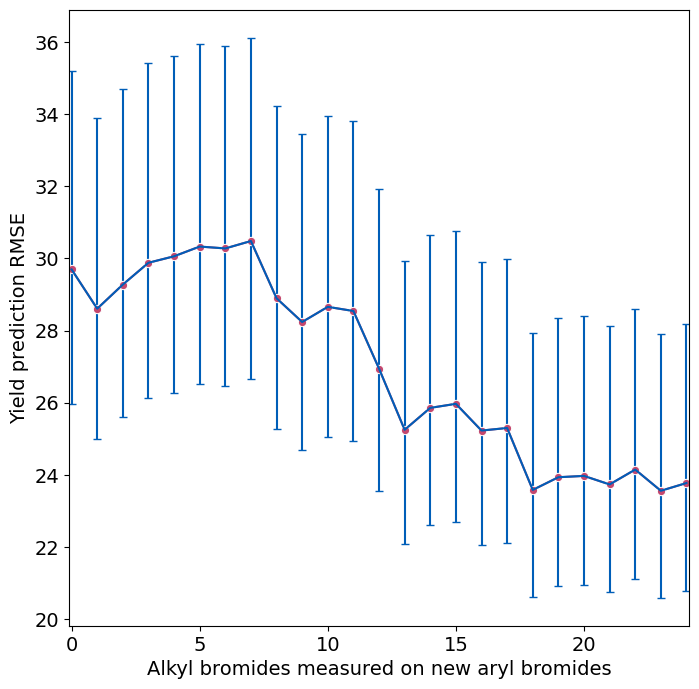

In [41]:
plt.figure(figsize=(8,8))
plt.errorbar(df_pred["iter"], df_pred["rmse"], yerr=[df_pred["rmse"] - df_pred["rmse_lower"], df_pred["rmse_upper"] - df_pred["rmse"]], capsize=3)
sns.lineplot(data=df_pred, x="iter", y="rmse", marker="o")
#plt.scatter(df_pred["index"], df_pred["rmse_upper"], color="tab:blue", alpha=0.5, s=20)
#plt.scatter(df_pred["index"], df_pred["rmse_lower"], color="tab:blue", alpha=0.5, s=20)
plt.ylabel("Yield prediction RMSE")
plt.xlabel("Alkyl bromides measured on new aryl bromides")
plt.xlim([-0.1,24.1])
#plt.ylim([0,30])
plt.show()

In [42]:

# train model on og core data + adding data for new cores 1 alkyl bromide at a time
threshold = 10
repeats = 10
results = []

for rep in range(repeats):
    df_train_aug = df_train.copy() # so we don't muss up df_train when we add new core data to it
    model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=rep)
    model.fit(df_train_aug[f_cols], df_train_aug[target])
    pred = model.predict(df_test[f_cols])
    model_results = {0: score_regression(df_test[target], pred)}
    rmse, rmse_lower, rmse_higher = root_mean_squared_error(df_test[target], pred, ci_method="chi_squared")
    model_results[0]["rmse_v"] = rmse
    model_results[0]["rmse_lower"] = rmse_lower
    model_results[0]["rmse_upper"] = rmse_higher
    model_results[0][f"acc_20"] = sklearn.metrics.accuracy_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
    model_results[0][f"recall_20"] = sklearn.metrics.recall_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
    model_results[0][f"precision_20"] = sklearn.metrics.precision_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
    model_results[0][f"f1_20"] = sklearn.metrics.f1_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(df_test["CAD Yield (%)"] > threshold, pred)
    model_results[0]["prc-auc_20"] = sklearn.metrics.auc(recall, precision)

    for num_mol, i in enumerate(df_mnc["selection_order"].unique()):
        df_mnc_next = df_mnc[df_mnc["selection_order"] == i] # next alkyl bromide to add
        assert len(df_mnc_next["smiles_alkyl"].unique()) == 1
        df_train_aug = pd.concat([df_train_aug, df_mnc_next])
        print(num_mol, df_train_aug.shape)

        model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=rep)
        model.fit(df_train_aug[f_cols], df_train_aug[target])
        pred = model.predict(df_test[f_cols])
        rmse, rmse_lower, rmse_higher = root_mean_squared_error(df_test[target], pred, ci_method="chi_squared")
        model_results[num_mol+1] = score_regression(df_test[target], pred)
        model_results[num_mol+1]["rmse_v"] = rmse
        model_results[num_mol+1]["rmse_lower"] = rmse_lower
        model_results[num_mol+1]["rmse_upper"] = rmse_higher
        model_results[num_mol+1][f"acc_20"] = sklearn.metrics.accuracy_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
        model_results[num_mol+1][f"recall_20"] = sklearn.metrics.recall_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
        model_results[num_mol+1][f"precision_20"] = sklearn.metrics.precision_score(df_test["CAD Yield (%)"] > threshold, pred > threshold, zero_division=0)
        model_results[num_mol+1][f"f1_20"] = sklearn.metrics.f1_score(df_test["CAD Yield (%)"] > threshold, pred > threshold)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(df_test["CAD Yield (%)"] > threshold, pred)
        model_results[num_mol+1]["prc-auc_20"] = sklearn.metrics.auc(recall, precision)
    
    df_pred = pd.DataFrame.from_dict(model_results, orient="index")
    results.append(df_pred)

print(len(df_pred))

0 (344, 2149)
1 (348, 2149)
2 (352, 2149)
3 (356, 2149)
4 (360, 2149)
5 (363, 2149)
6 (367, 2149)
7 (371, 2149)
8 (373, 2149)
9 (377, 2149)
10 (381, 2149)
11 (384, 2149)
12 (388, 2149)
13 (392, 2149)
14 (396, 2149)
15 (399, 2149)
16 (402, 2149)
17 (406, 2149)
18 (410, 2149)
19 (414, 2149)
20 (418, 2149)
21 (422, 2149)
22 (426, 2149)
23 (430, 2149)
0 (344, 2149)
1 (348, 2149)
2 (352, 2149)
3 (356, 2149)
4 (360, 2149)
5 (363, 2149)
6 (367, 2149)
7 (371, 2149)
8 (373, 2149)
9 (377, 2149)
10 (381, 2149)
11 (384, 2149)
12 (388, 2149)
13 (392, 2149)
14 (396, 2149)
15 (399, 2149)
16 (402, 2149)
17 (406, 2149)
18 (410, 2149)
19 (414, 2149)
20 (418, 2149)
21 (422, 2149)
22 (426, 2149)
23 (430, 2149)
0 (344, 2149)
1 (348, 2149)
2 (352, 2149)
3 (356, 2149)
4 (360, 2149)
5 (363, 2149)
6 (367, 2149)
7 (371, 2149)
8 (373, 2149)
9 (377, 2149)
10 (381, 2149)
11 (384, 2149)
12 (388, 2149)
13 (392, 2149)
14 (396, 2149)
15 (399, 2149)
16 (402, 2149)
17 (406, 2149)
18 (410, 2149)
19 (414, 2149)
20 (418, 2

In [51]:
results[0].index.rename("iter", inplace=True)

In [53]:
results[0].reset_index()

,iter,r2,mae,rmse,spearmanr,rmse_v,rmse_lower,rmse_upper,acc_20,recall_20,precision_20,f1_20,prc-auc_20
0,0,0.284875,16.088310,28.955448,"(0.5123221121889143, 5.382199225387635e-07)",28.955448,25.310740,34.309881,0.717647,0.619048,0.448276,0.520000,0.636569
1,1,0.291509,16.000164,28.820827,"(0.49488643094869367, 1.4754245208938939e-06)",28.820827,25.193064,34.150366,0.717647,0.619048,0.448276,0.520000,0.588422
2,2,0.263118,15.350585,29.392633,"(0.5110640946817084, 5.799337899260138e-07)",29.392633,25.692896,34.827910,0.764706,0.619048,0.520000,0.565217,0.680185
3,3,0.232447,15.385764,29.998091,"(0.5159637418150363, 4.328919150396659e-07)",29.998091,26.222143,35.545330,0.788235,0.619048,0.565217,0.590909,0.655365
4,4,0.217022,15.890896,30.298013,"(0.5029200866087447, 9.335433631478781e-07)",30.298013,26.484313,35.900713,0.776471,0.619048,0.541667,0.577778,0.632427
5,5,0.225413,15.811384,30.135218,"(0.48733832590545884, 2.2445806836986925e-06)",30.135218,26.342010,35.707815,0.776471,0.619048,0.541667,0.577778,0.619689
6,6,0.221168,15.867811,30.217696,"(0.4873824668706239, 2.2391449042320118e-06)",30.217696,26.414105,35.805544,0.752941,0.571429,0.500000,0.533333,0.618442
7,7,0.215707,15.436350,30.323439,"(0.4970714087243669, 1.3042252143165266e-06)",30.323439,26.506538,35.930841,0.788235,0.571429,0.571429,0.571429,0.651056
8,8,0.311836,15.005785,28.404374,"(0.4998522895297691, 1.1133745967498126e-06)",28.404374,24.829032,33.656903,0.741176,0.619048,0.481481,0.541667,0.673572
9,9,0.342179,14.768126,27.771100,"(0.5092101741447737, 6.470189175276057e-07)",27.771100,24.275470,32.906524,0.752941,0.619048,0.500000,0.553191,0.670685


In [54]:
for df in results:
    df.index.rename("iter", inplace=True)
    df.reset_index(inplace=True)
results[0]

,iter,r2,mae,rmse,spearmanr,rmse_v,rmse_lower,rmse_upper,acc_20,recall_20,precision_20,f1_20,prc-auc_20
0,0,0.284875,16.088310,28.955448,"(0.5123221121889143, 5.382199225387635e-07)",28.955448,25.310740,34.309881,0.717647,0.619048,0.448276,0.520000,0.636569
1,1,0.291509,16.000164,28.820827,"(0.49488643094869367, 1.4754245208938939e-06)",28.820827,25.193064,34.150366,0.717647,0.619048,0.448276,0.520000,0.588422
2,2,0.263118,15.350585,29.392633,"(0.5110640946817084, 5.799337899260138e-07)",29.392633,25.692896,34.827910,0.764706,0.619048,0.520000,0.565217,0.680185
3,3,0.232447,15.385764,29.998091,"(0.5159637418150363, 4.328919150396659e-07)",29.998091,26.222143,35.545330,0.788235,0.619048,0.565217,0.590909,0.655365
4,4,0.217022,15.890896,30.298013,"(0.5029200866087447, 9.335433631478781e-07)",30.298013,26.484313,35.900713,0.776471,0.619048,0.541667,0.577778,0.632427
5,5,0.225413,15.811384,30.135218,"(0.48733832590545884, 2.2445806836986925e-06)",30.135218,26.342010,35.707815,0.776471,0.619048,0.541667,0.577778,0.619689
6,6,0.221168,15.867811,30.217696,"(0.4873824668706239, 2.2391449042320118e-06)",30.217696,26.414105,35.805544,0.752941,0.571429,0.500000,0.533333,0.618442
7,7,0.215707,15.436350,30.323439,"(0.4970714087243669, 1.3042252143165266e-06)",30.323439,26.506538,35.930841,0.788235,0.571429,0.571429,0.571429,0.651056
8,8,0.311836,15.005785,28.404374,"(0.4998522895297691, 1.1133745967498126e-06)",28.404374,24.829032,33.656903,0.741176,0.619048,0.481481,0.541667,0.673572
9,9,0.342179,14.768126,27.771100,"(0.5092101741447737, 6.470189175276057e-07)",27.771100,24.275470,32.906524,0.752941,0.619048,0.500000,0.553191,0.670685


In [55]:
df_pred_mean = pd.concat(results).drop(columns="spearmanr").groupby("iter").mean()
df_pred_std = pd.concat(results).drop(columns="spearmanr").groupby("iter").std()
df_pred_std

,r2,mae,rmse,rmse_v,rmse_lower,rmse_upper,acc_20,recall_20,precision_20,f1_20,prc-auc_20
iter,,,,,,,,,,,
0,0.010362,0.057754,0.208682,0.208682,0.182415,0.247272,0.005683,0.000000,0.007733,0.005126,0.043349
1,0.008848,0.089546,0.180215,0.180215,0.157531,0.213540,0.006075,0.000000,0.008267,0.005480,0.014019
2,0.010173,0.082485,0.204248,0.204248,0.178539,0.242018,0.007843,0.000000,0.012845,0.007851,0.007164
3,0.012643,0.080082,0.249589,0.249589,0.218173,0.295743,0.007941,0.000000,0.016890,0.009146,0.009059
4,0.010069,0.077130,0.196393,0.196393,0.171672,0.232709,0.007441,0.000000,0.013358,0.007832,0.012815
5,0.008114,0.047024,0.157858,0.157858,0.137988,0.187049,0.008681,0.000000,0.015441,0.009092,0.009218
6,0.007678,0.056198,0.148957,0.148957,0.130207,0.176502,0.010301,0.033296,0.018278,0.023771,0.010301
7,0.009571,0.071911,0.185464,0.185464,0.162119,0.219759,0.009280,0.033296,0.017643,0.022187,0.010682
8,0.011599,0.123676,0.239139,0.239139,0.209038,0.283361,0.009280,0.000000,0.015113,0.009261,0.007002


In [56]:
results_cat = pd.concat(results)

In [57]:
results_cat.to_csv("figure_data/partial_batch_predictions_repeats.csv")

In [58]:
results_cat = pd.read_csv("figure_data/partial_batch_predictions_repeats.csv")

In [60]:
plt.rcParams.update({"font.size":9})

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




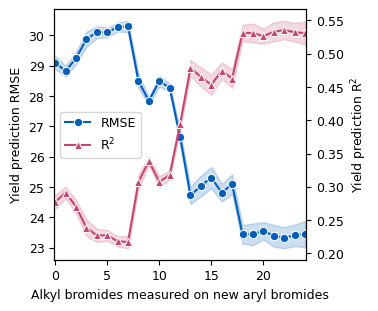

In [62]:
fig, ax1 = plt.subplots(figsize=(3.25,3.25))

sns.lineplot(data=results_cat, x="iter", y="rmse", ci="sd", marker="o", ax=ax1, label="RMSE", legend=False, color="C0")
ax1.set_ylabel("Yield prediction RMSE")
ax1.set_xlabel("Alkyl bromides measured on new aryl bromides")
ax1.set_xlim([-0.1,24.1])
#plt.ylim([0,30])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

sns.lineplot(data=results_cat, x="iter", y="r2", marker="^", ci="sd", ax=ax2, label=r"R$^2$", color="C1")
ax2.set_ylabel(f"Yield prediction R$^2$")
ax2.set_xlabel("Alkyl bromides measured on new aryl bromides")
ax2.set_xlim([-0.1,24.1])

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles += handles2
labels += labels2

# Create a single legend
plt.legend(handles, labels, loc=6)
#plt.show()
plt.savefig("images/partial_batch_predictions_repeats.png", dpi=300, bbox_inches="tight")